# Azure AI Custom Vision image classification project export

This notebook demonstrates how to export all images and labels from an Azure AI Custom Vision image classification project.”

In [1]:
#%pip install azure-cognitiveservices-vision-customvision

In [2]:
import datetime
import os
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shutil
import sys

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from dotenv import load_dotenv
from IPython.display import FileLink
from msrest.authentication import ApiKeyCredentials
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from pathlib import Path
from tqdm import tqdm
from typing import Optional

In [3]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 12-Jan-2026 09:33:25


## 1. Settings

In [5]:
load_dotenv("azure.env")

ENDPOINT = os.getenv("ENDPOINT_IC")
TRAINING_KEY = os.getenv("TRAINING_KEY_IC")
PROJECT_ID = os.getenv("PROJECT_ID_IC")

In [6]:
OUTPUT_DIR = f"image_classification_projects"
IMAGES_DIR = os.path.join(OUTPUT_DIR, PROJECT_ID, "images")
LABELS_DIR = os.path.join(OUTPUT_DIR, PROJECT_ID, "labels")
ZIP_DIR = "zip"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(LABELS_DIR, exist_ok=True)
os.makedirs(ZIP_DIR, exist_ok=True)

## 2. Helper

In [7]:
def get_images(
    endpoint: str,
    training_key: str,
    project_id: str,
    output_dir: str = "exported_images",
    export_metadata: bool = True,
    debug: bool = False):
    """
    Download all tagged images from a Custom Vision project.
    
    Args:
        endpoint: Custom Vision training endpoint URL
        training_key: Training API key
        project_id: The Custom Vision project ID
        output_dir: Directory to save downloaded images
        export_metadata: Whether to export a JSON file with image metadata
        debug: If True, print the first image's attributes for debugging
    """

    # Create the training client
    credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
    trainer = CustomVisionTrainingClient(endpoint, credentials)

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get all tags in the project
    print("Fetching tags from project...")
    tags = trainer.get_tags(project_id)
    tag_map = {tag.id: tag.name for tag in tags}
    print(f"Found {len(tags)} tags: {list(tag_map.values())}")

    # Create subdirectories for each tag
    for tag_name in tag_map.values():
        tag_dir = os.path.join(output_dir, sanitize_filename(tag_name))
        os.makedirs(tag_dir, exist_ok=True)

    # Get tagged images with pagination
    print("\nFetching tagged images...")
    all_images = []
    skip = 0
    take = 256  # Maximum allowed per request

    with tqdm(desc="Retrieving image list", unit=" images") as pbar:
        while True:
            images = trainer.get_tagged_images(project_id, take=take, skip=skip)

            if not images:
                break

            all_images.extend(images)
            pbar.update(len(images))

            if len(images) < take:
                break
            skip += take

    print(f"Total images found = {len(all_images)}")

    # Debug: inspect first image object
    if debug and all_images:
        inspect_image_object(all_images[0])

    # Download each image
    metadata = []
    downloaded_count = 0
    failed_count = 0

    for image in tqdm(all_images, desc="Downloading images", unit="img"):
        try:
            # Get tag names for this image
            image_tags = [
                tag_map.get(tag.tag_id, "unknown") for tag in image.tags
            ]

            # Determine primary tag (first tag) for folder organization
            primary_tag = image_tags[0] if image_tags else "untagged"

            # Build filename - use image ID as base since original_file_name may not exist
            image_id = image.id

            # Try to get original filename if available
            original_name = None
            for attr in ['original_file_name', 'file_name', 'name']:
                if hasattr(image, attr) and getattr(image, attr):
                    original_name = getattr(image, attr)
                    break

            if not original_name:
                original_name = f"image_{image_id}.jpg"

            # Ensure valid extension
            if not any(original_name.lower().endswith(ext)
                       for ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']):
                original_name += '.jpg'

            # Download URL - try multiple possible attributes
            image_url = None
            for uri_attr in [
                    'original_file_name_uri', 'resized_image_uri',
                    'thumbnail_uri'
            ]:
                if hasattr(image, uri_attr) and getattr(image, uri_attr):
                    image_url = getattr(image, uri_attr)
                    break

            if not image_url:
                failed_count += 1
                continue

            # Download the image
            response = requests.get(image_url, timeout=30)
            response.raise_for_status()

            # Save to tag-specific folder
            safe_tag = sanitize_filename(primary_tag)
            save_path = os.path.join(output_dir, safe_tag,
                                     f"{image_id}_{original_name}")

            with open(save_path, 'wb') as f:
                f.write(response.content)

            # Collect metadata
            image_metadata = {
                "id": str(image_id),
                "original_filename": original_name,
                "saved_path": save_path,
                "tags": image_tags,
                "tag_details": [{
                    "tag_id": str(tag.tag_id),
                    "tag_name": tag_map.get(tag.tag_id, "unknown"),
                    "created": str(tag.created) if hasattr(tag, 'created') else None
                } for tag in image.tags],
                "width": getattr(image, 'width', None),
                "height": getattr(image, 'height', None),
                "created": str(image.created) if hasattr(image, 'created') and image.created else None,
                "image_uri": image_url
            }
            metadata.append(image_metadata)
            downloaded_count += 1

        except Exception as e:
            tqdm.write(f"Error downloading image {image.id}: {e}")
            failed_count += 1

    # Export metadata to JSON
    if export_metadata:
        metadata_path = os.path.join(output_dir, "images_metadata.json")
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(
                {
                    "project_id": project_id,
                    "total_images": len(all_images),
                    "downloaded": downloaded_count,
                    "failed": failed_count,
                    "tags": list(tag_map.values()),
                    "images": metadata
                },
                f,
                indent=2,
                ensure_ascii=False)
        print(f"\nMetadata exported to: {metadata_path}")

    # Export tags summary as CSV
    tags_csv_path = os.path.join(output_dir, "images.csv")
    with open(tags_csv_path, 'w', encoding='utf-8') as f:
        f.write("image_id,filename,tags\n")
        for img in metadata:
            tags_str = "|".join(img["tags"])
            f.write(f'{img["id"]},{img["original_filename"]},"{tags_str}"\n')
    print(f"Tags CSV exported to: {tags_csv_path}")

    print(f"\n{'='*50}")
    print(f"Download complete!")
    print(f"  - Successfully downloaded: {downloaded_count}")
    print(f"  - Failed: {failed_count}")
    print(f"  - Output directory: {output_dir}")
    print(f"{'='*50}")

    return metadata


def sanitize_filename(name: str) -> str:
    """Remove or replace characters that are invalid in filenames."""
    invalid_chars = '<>:"/\\|?*'
    for char in invalid_chars:
        name = name.replace(char, '_')
        
    return name.strip()


def inspect_image_object(image, max_images: int = 1):
    """Debug helper: Print all attributes of an Image object."""
    print("\n" + "=" * 60)
    print("IMAGE OBJECT INSPECTION (for debugging)")
    print("=" * 60)
    print(f"Type: {type(image)}")
    print("\nAttributes:")
    for attr in dir(image):
        if not attr.startswith('_'):
            try:
                value = getattr(image, attr)
                if not callable(value):
                    # Truncate long values
                    str_value = str(value)
                    if len(str_value) > 100:
                        str_value = str_value[:100] + "..."
                    print(f"  {attr}: {str_value}")
            except Exception as e:
                print(f"  {attr}: <error: {e}>")
    print("=" * 60 + "\n")


def list_projects(endpoint: str, training_key: str):
    """List all projects in the Custom Vision account."""
    credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
    trainer = CustomVisionTrainingClient(endpoint, credentials)

    projects = trainer.get_projects()
    print("Available projects:\n")
    for project in projects:
        print(f"  Name: {project.name}")
        print(f"  ID: {project.id}")
        print(f"  Description: {project.description or 'N/A'}")


def images_view(image_dir, n=12, cols=4):
    """
    Display images with size and dimension info.
    """
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp'}

    image_files = sorted([
        f for f in os.listdir(image_dir)
        if os.path.splitext(f)[1].lower() in valid_extensions
    ])[:n]

    if not image_files:
        print(f"⚠️ No images found in {image_dir}")
        return

    rows = (len(image_files) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4.5 * rows))
    axes = axes.flatten() if len(image_files) > 1 else [axes]

    print(f"🖼️ Displaying {len(image_files)} images from: {image_dir}\n")

    for idx, ax in enumerate(axes):
        if idx < len(image_files):
            img_path = os.path.join(image_dir, image_files[idx])
            img = Image.open(img_path)
            file_size = os.path.getsize(img_path) / 1024  # KB

            ax.imshow(img)
            ax.set_title(
                f"{image_files[idx][:15]}...\n{img.size[0]}x{img.size[1]} | {file_size:.1f}KB",
                fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


def get_exif_data(image: Image.Image) -> dict:
    """Extract EXIF metadata from an image."""
    exif_data = {}
    try:
        exif = image._getexif()
        if exif:
            for tag_id, value in exif.items():
                tag = TAGS.get(tag_id, tag_id)
                if isinstance(value, bytes):
                    try:
                        value = value.decode("utf-8", errors="ignore")
                    except:
                        value = str(value)[:50]
                exif_data[tag] = value
    except Exception:
        pass
    return exif_data


def get_image_info(filepath: Path) -> Optional[dict]:
    """Extract comprehensive information from a single image file."""
    try:
        stat = filepath.stat()
        
        # Basic file info
        info = {
            "filename": filepath.name,
            "filepath": str(filepath),
            "extension": filepath.suffix.lower(),
            "file_size_bytes": stat.st_size,
            "file_size_kb": round(stat.st_size / 1024, 2),
            "file_size_mb": round(stat.st_size / (1024 * 1024), 4),
            "created_date": datetime.datetime.fromtimestamp(stat.st_ctime),
            "modified_date": datetime.datetime.fromtimestamp(stat.st_mtime),
            "accessed_date": datetime.datetime.fromtimestamp(stat.st_atime),
        }
        
        # Open image and extract properties
        with Image.open(filepath) as img:
            info["width"] = img.width
            info["height"] = img.height
            info["aspect_ratio"] = round(img.width / img.height, 3) if img.height > 0 else None
            info["megapixels"] = round((img.width * img.height) / 1_000_000, 2)
            info["format"] = img.format
            info["mode"] = img.mode  # RGB, RGBA, L (grayscale), etc.
            info["is_animated"] = getattr(img, "is_animated", False)
            info["n_frames"] = getattr(img, "n_frames", 1)
            
            # Color depth / bits per pixel
            mode_to_bits = {
                "1": 1, "L": 8, "P": 8, "RGB": 24, "RGBA": 32,
                "CMYK": 32, "YCbCr": 24, "LAB": 24, "HSV": 24,
                "I": 32, "F": 32, "LA": 16, "PA": 16, "RGBa": 32,
                "La": 16, "PA": 16
            }
            info["bits_per_pixel"] = mode_to_bits.get(img.mode, None)
            info["n_channels"] = len(img.getbands())
            info["channels"] = ", ".join(img.getbands())
            
            # DPI info
            dpi = img.info.get("dpi")
            if dpi:
                info["dpi_x"] = dpi[0]
                info["dpi_y"] = dpi[1]
            else:
                info["dpi_x"] = None
                info["dpi_y"] = None
            
            # EXIF data
            exif = get_exif_data(img)
            info["camera_make"] = exif.get("Make")
            info["camera_model"] = exif.get("Model")
            info["date_taken"] = exif.get("DateTimeOriginal") or exif.get("DateTime")
            info["exposure_time"] = exif.get("ExposureTime")
            info["f_number"] = exif.get("FNumber")
            info["iso"] = exif.get("ISOSpeedRatings")
            info["focal_length"] = exif.get("FocalLength")
            info["flash"] = exif.get("Flash")
            info["orientation"] = exif.get("Orientation")
            info["software"] = exif.get("Software")
            info["has_exif"] = len(exif) > 0
            
            # Transparency
            info["has_transparency"] = img.mode in ("RGBA", "LA", "PA") or "transparency" in img.info
            
        return info
        
    except Exception as e:
        return {
            "filename": filepath.name,
            "filepath": str(filepath),
            "error": str(e)
        }


def analyze_images(directory: str, recursive: bool = True) -> pd.DataFrame:
    """
    Analyze all images in a directory and return a DataFrame with metadata.
    
    Parameters:
    -----------
    directory : str
        Path to the directory containing images
    recursive : bool
        If True, search subdirectories as well
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing image metadata
    """
    image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".tif", 
                        ".webp", ".ico", ".svg", ".heic", ".heif", ".raw", ".cr2", 
                        ".nef", ".arw", ".dng"}
    
    dir_path = Path(directory)
    if not dir_path.exists():
        raise ValueError(f"Directory not found: {directory}\n")
    
    # Find all image files
    if recursive:
        files = [f for f in dir_path.rglob("*") if f.suffix.lower() in image_extensions]
    else:
        files = [f for f in dir_path.glob("*") if f.suffix.lower() in image_extensions]
    
    print(f"Found {len(files)} image files in '{directory}'")
    
    # Process each image
    results = []
    for i, filepath in enumerate(files, 1):
        if i % 100 == 0:
            print(f"Processing {i}/{len(files)}...")
        info = get_image_info(filepath)
        if info:
            results.append(info)
    
    df = pd.DataFrame(results)
    
    # Reorder columns for better readability
    priority_cols = [
        "filename", "filepath", "extension", "format", "width", "height",
        "aspect_ratio", "megapixels", "mode", "n_channels", "channels",
        "bits_per_pixel", "file_size_kb", "file_size_mb",
        "created_date", "modified_date", "date_taken",
        "has_exif", "camera_make", "camera_model"
    ]
    
    other_cols = [c for c in df.columns if c not in priority_cols]
    ordered_cols = [c for c in priority_cols if c in df.columns] + other_cols
    df = df[ordered_cols]
    print("Done")
    
    return df


def print_summary(df: pd.DataFrame):
    """Print a summary of the image analysis."""
    print("\n" + "=" * 60)
    print("IMAGE DATASET SUMMARY")
    print("=" * 60)
    
    print(f"\nTotal images: {len(df)}")
    
    if "error" in df.columns:
        errors = df["error"].notna().sum()
        if errors > 0:
            print(f"Failed to process: {errors} images")
    
    # Format distribution
    if "format" in df.columns:
        print("\n📁 Format Distribution:")
        print(df["format"].value_counts().to_string())
    
    # Dimensions
    if "width" in df.columns and "height" in df.columns:
        print("\n📐 Dimensions:")
        print(f"  Width:  min={df['width'].min()}, max={df['width'].max()}, mean={df['width'].mean():.0f}")
        print(f"  Height: min={df['height'].min()}, max={df['height'].max()}, mean={df['height'].mean():.0f}")
    
    # File sizes
    if "file_size_mb" in df.columns:
        print("\n💾 File Sizes:")
        print(f"  Total: {df['file_size_mb'].sum():.2f} MB")
        print(f"  Mean:  {df['file_size_mb'].mean():.2f} MB")
        print(f"  Min:   {df['file_size_mb'].min():.4f} MB")
        print(f"  Max:   {df['file_size_mb'].max():.2f} MB")
    
    # Color modes
    if "mode" in df.columns:
        print("\n🎨 Color Modes:")
        print(df["mode"].value_counts().to_string())
    
    # EXIF data
    if "has_exif" in df.columns:
        exif_count = df["has_exif"].sum()
        print(f"\n📷 Images with EXIF data: {exif_count} ({100*exif_count/len(df):.1f}%)")
    
    # Cameras
    if "camera_model" in df.columns:
        cameras = df["camera_model"].dropna().value_counts()
        if len(cameras) > 0:
            print("\n📸 Camera Models:")
            print(cameras.head(10).to_string())


## 3. List all Azure AI Custom Vision projects

In [8]:
list_projects(ENDPOINT, TRAINING_KEY)

Available projects:

  Name: Garbage classification
  ID: b1d711e4-03c2-4132-baaf-65475be15619
  Description: Garbage classification demo
  Name: Car damage image classification
  ID: 3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286
  Description: Image classification project to classify vehicles damages


## 4. Project information

In [9]:
# Initialize client
credentials = ApiKeyCredentials(in_headers={"Training-key": TRAINING_KEY})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)

# Get project details
project = trainer.get_project(PROJECT_ID)

print("\033[1;31;34m")
print("=" * 50)
print("PROJECT INFORMATION")
print("=" * 50)

print(f"Name: {project.name}")
print(f"ID: {project.id}")
print(f"Description: {project.description}")
print(f"Domain: {project.settings.domain_id}")
print(f"Classification Type: {project.settings.classification_type}")
print(f"Target Export Platforms: {project.settings.target_export_platforms}")
print(f"Created: {project.created}")
print(f"Last Modified: {project.last_modified}")

# Get tags (labels)
print("\n" + "=" * 50)
print("TAGS")
print("=" * 50)

tags = trainer.get_tags(PROJECT_ID)
for tag in tags:
    print(f"  - {tag.name}: {tag.image_count} images")

# Get iterations (trained models)
print("\n" + "=" * 50)
print("ITERATIONS (TRAINED MODELS)")
print("=" * 50)

iterations = trainer.get_iterations(PROJECT_ID)
for iteration in iterations:
    status = "✓ Published" if iteration.publish_name else "Not published"
    print(f"  - {iteration.name}")
    print(f"    Status: {iteration.status} | {status}")
    print(f"    Created: {iteration.created}")
    if iteration.publish_name:
        print(f"    Publish Name: {iteration.publish_name}")

# Get image counts
print("\n" + "=" * 50)
print("IMAGE STATISTICS")
print("=" * 50)

tagged_count = trainer.get_tagged_image_count(PROJECT_ID)
untagged_count = trainer.get_untagged_image_count(PROJECT_ID)
print(f"Tagged images: {tagged_count}")
print(f"Untagged images: {untagged_count}")
print(f"Total images: {tagged_count + untagged_count}")

# Get performance of the latest published iteration
if iterations:
    latest_trained = [i for i in iterations if i.status == "Completed"]
    if latest_trained:
        perf = trainer.get_iteration_performance(PROJECT_ID, latest_trained[0].id)
        print("\n" + "=" * 50)
        print(f"PERFORMANCE ({latest_trained[0].name})")
        print("=" * 50)
        print(f"Precision: {perf.precision:.2%}")
        print(f"Recall: {perf.recall:.2%}")
        print(f"Average Precision (mAP): {perf.average_precision:.2%}")
        
        print("\nPer-tag performance:")
        for tag_perf in perf.per_tag_performance:
            print(f"  {tag_perf.name}:")
            print(f"    Precision: {tag_perf.precision:.2%} | Recall: {tag_perf.recall:.2%}")


PROJECT INFORMATION
Name: Car damage image classification
ID: 3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286
Description: Image classification project to classify vehicles damages
Domain: a1db07ca-a19a-4830-bae8-e004a42dc863
Classification Type: Multiclass
Target Export Platforms: []
Created: 2024-12-16 09:28:18.810000+00:00
Last Modified: 2024-12-16 09:28:18.810000+00:00

TAGS
  - damage: 357 images
  - no_damage: 358 images

ITERATIONS (TRAINED MODELS)
  - Iteration 2
    Status: Completed | ✓ Published
    Created: 2024-12-16 09:29:47.160000+00:00
    Publish Name: car_damage_classification_model
  - Iteration 1
    Status: Completed | Not published
    Created: 2024-12-16 09:28:18.810000+00:00

IMAGE STATISTICS
Tagged images: 715
Untagged images: 0
Total images: 715

PERFORMANCE (Iteration 2)
Precision: 97.01%
Recall: 90.28%
Average Precision (mAP): 98.12%

Per-tag performance:
  damage:
    Precision: 96.92% | Recall: 87.50%
  no_damage:
    Precision: 97.10% | Recall: 93.06%


## 5. Get images and labels

In [10]:
get_images(
    endpoint=ENDPOINT,
    training_key=TRAINING_KEY,
    project_id=PROJECT_ID,
    output_dir=IMAGES_DIR,
    export_metadata=True,
    debug=True,
)

print(f"\n✅ Done")

Fetching tags from project...
Found 2 tags: ['damage', 'no_damage']

Fetching tagged images...


Retrieving image list: 715 images [00:15, 47.30 images/s]


Total images found = 715

IMAGE OBJECT INSPECTION (for debugging)
Type: <class 'azure.cognitiveservices.vision.customvision.training.models._models_py3.Image'>

Attributes:
  additional_properties: {}
  created: 2024-12-16 09:29:43.633677
  height: 183
  id: 1b207964-d2db-403e-b3ce-4754a94abd0f
  metadata: None
  original_image_uri: https://irisprodwetraining.blob.core.windows.net:443/i-3ee6d4f17f9f4aaeb13fd5c4ef583286/i-1b207964d2...
  regions: None
  resized_image_uri: https://irisprodwetraining.blob.core.windows.net:443/i-3ee6d4f17f9f4aaeb13fd5c4ef583286/i-1b207964d2...
  tags: [<azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageTag object at 0x71938...
  thumbnail_uri: https://irisprodwetraining.blob.core.windows.net:443/i-3ee6d4f17f9f4aaeb13fd5c4ef583286/t-1b207964d2...
  width: 275




Metadata exported to: image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/images/images_metadata.json
Tags CSV exported to: image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/images/images.csv

Download complete!
  - Successfully downloaded: 715
  - Failed: 0
  - Output directory: image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/images

✅ Done


## 6. Export results

In [11]:
!ls $IMAGES_DIR -lh

total 843K
drwxrwxrwx 2 root root    0 Jan 12 09:33 damage
-rwxrwxrwx 1 root root  67K Jan 12 09:34 images.csv
-rwxrwxrwx 1 root root 776K Jan 12 09:34 images_metadata.json
drwxrwxrwx 2 root root    0 Jan 12 09:33 no_damage


In [12]:
df_images = pd.read_csv(os.path.join(IMAGES_DIR, "images.csv"))
df_images

,image_id,filename,tags
0,1b207964-d2db-403e-b3ce-4754a94abd0f,image_1b207964-d2db-403e-b3ce-4754a94abd0f.jpg,no_damage
1,44375b99-4229-4186-865a-5964bd81328e,image_44375b99-4229-4186-865a-5964bd81328e.jpg,no_damage
2,0bfc2882-9117-4289-9333-97baeb51581a,image_0bfc2882-9117-4289-9333-97baeb51581a.jpg,no_damage
3,2c71e8c5-1da9-433a-ade2-4a42b4c315b2,image_2c71e8c5-1da9-433a-ade2-4a42b4c315b2.jpg,no_damage
4,67d57f3e-0558-4214-af2d-ace4d81589c4,image_67d57f3e-0558-4214-af2d-ace4d81589c4.jpg,no_damage
...,...,...,...
710,cc9f3482-1ecc-4d7e-a48d-a68a022c0701,image_cc9f3482-1ecc-4d7e-a48d-a68a022c0701.jpg,damage
711,0f709d92-fc4b-4d09-87fb-aa40906ad98d,image_0f709d92-fc4b-4d09-87fb-aa40906ad98d.jpg,damage
712,13419d29-fbc2-47ff-a293-77529d5ecb58,image_13419d29-fbc2-47ff-a293-77529d5ecb58.jpg,damage
713,82d2dd2b-8d5d-4cd0-b9e6-4140f7a31df7,image_82d2dd2b-8d5d-4cd0-b9e6-4140f7a31df7.jpg,damage


In [13]:
# Saving into csv and excel files
df_images.to_csv(os.path.join(OUTPUT_DIR, PROJECT_ID, "images.csv"), index=False)
df_images.to_excel(os.path.join(OUTPUT_DIR, PROJECT_ID, "images.xlsx"), index=False)

In [14]:
labels_file = os.path.join(LABELS_DIR, 'labels.txt')

df_images['tags'].drop_duplicates().to_csv(labels_file, index=False, header=False)
!ls $labels_file -lh

-rwxrwxrwx 1 root root 17 Jan 12 09:34 image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/labels/labels.txt


In [15]:
with open(labels_file,'r') as f:
    print(f.read())

no_damage
damage



In [16]:
df_images['tags'].value_counts(normalize=True).mul(100).round(2)
counts = df_images['tags'].value_counts()
percentages = df_images['tags'].value_counts(normalize=True).mul(100).round(2)
summary = pd.DataFrame({'count': counts, 'percentage %': percentages})

print(summary)

           count  percentage %
tags                          
no_damage    358         50.07
damage       357         49.93


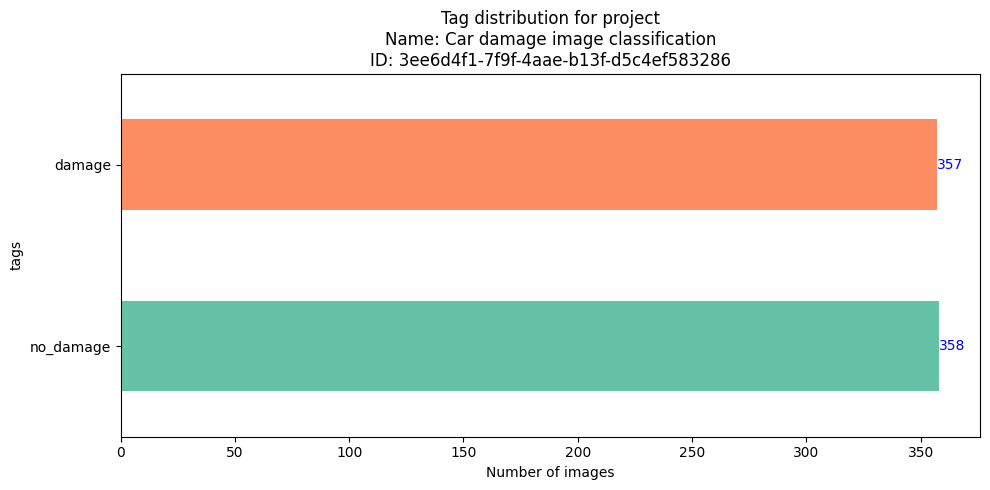

In [17]:
ax = df_images['tags'].value_counts().plot(kind='barh', figsize=(10, 5))
value_counts = df_images['tags'].value_counts()

colors = plt.cm.Set2(range(len(value_counts)))

ax = value_counts.plot(kind='barh', figsize=(10, 5), color=colors)
ax.bar_label(ax.containers[0], fmt='%d', color="blue")
plt.xlabel('Number of images')
plt.title(f"Tag distribution for project\nName: {project.name}\nID: {PROJECT_ID}", size=12)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, PROJECT_ID, "tags.png"), dpi=300)
plt.show()

Tag: no_damage
🖼️ Displaying 6 images from: image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/images/no_damage



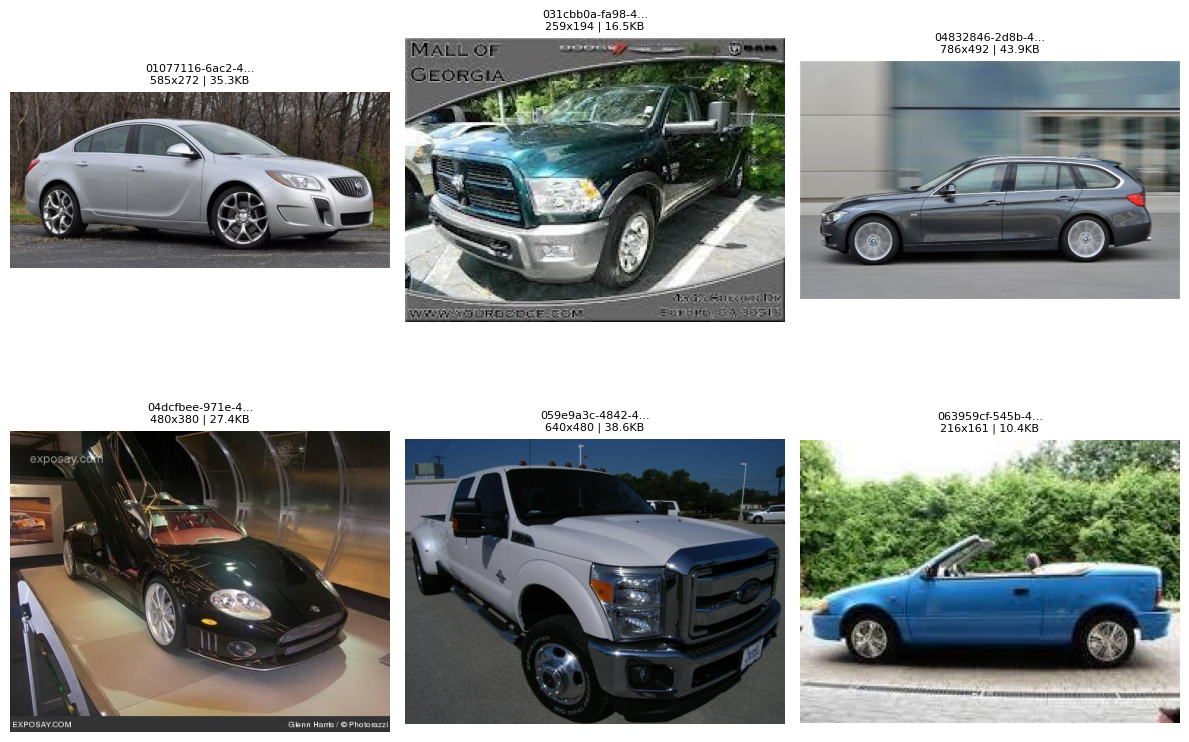

------------------------------------------------------------------------------------------------------------------------
Tag: damage
🖼️ Displaying 6 images from: image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/images/damage



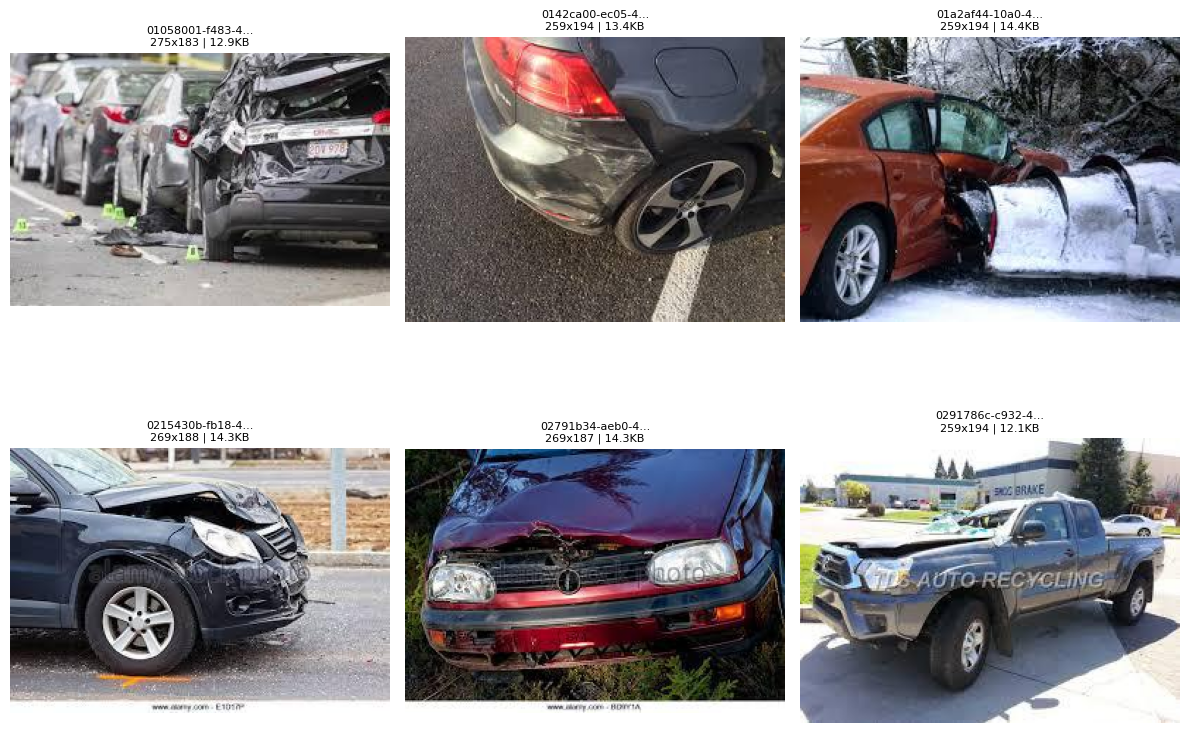

------------------------------------------------------------------------------------------------------------------------


In [18]:
tags_list = df_images['tags'].unique().tolist()

for idx in range(len(tags_list)):
    print(f"Tag: {tags_list[idx]}")
    images_view(os.path.join(IMAGES_DIR, tags_list[idx]), n=6, cols=3)
    print("-" * 120)

In [19]:
print(f"Analyzing images in: {IMAGES_DIR}\n")

df = analyze_images(IMAGES_DIR, recursive=True)
df    

Analyzing images in: image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/images

Found 715 image files in 'image_classification_projects/3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286/images'
Processing 100/715...
Processing 200/715...
Processing 300/715...
Processing 400/715...
Processing 500/715...
Processing 600/715...
Processing 700/715...
Done


,filename,filepath,extension,format,width,height,aspect_ratio,megapixels,mode,n_channels,...,dpi_x,dpi_y,exposure_time,f_number,iso,focal_length,flash,orientation,software,has_transparency
0,01058001-f483-4c8e-bf17-d8c6e37f416f_image_010...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,275,183,1.503,0.05,RGB,3,...,None,None,None,None,None,None,None,None,None,False
1,0142ca00-ec05-471e-b7c3-1a816c90f236_image_014...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,259,194,1.335,0.05,RGB,3,...,None,None,None,None,None,None,None,None,None,False
2,01a2af44-10a0-4899-99cf-fdfee4623ebd_image_01a...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,259,194,1.335,0.05,RGB,3,...,None,None,None,None,None,None,None,None,None,False
3,0215430b-fb18-4d07-9ccc-34c83090aaa6_image_021...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,269,188,1.431,0.05,RGB,3,...,None,None,None,None,None,None,None,None,None,False
4,02791b34-aeb0-4845-a583-e3d8af91cc7c_image_027...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,269,187,1.439,0.05,RGB,3,...,None,None,None,None,None,None,None,None,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,fb0131e0-f175-4e99-b7fa-a82bda7ea247_image_fb0...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,420,315,1.333,0.13,RGB,3,...,None,None,None,None,None,None,None,None,None,False
711,fe12f7a9-3f3a-4ea8-8c77-66266458ca67_image_fe1...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,300,225,1.333,0.07,RGB,3,...,None,None,None,None,None,None,None,None,None,False
712,ff1c951d-b620-42bd-b421-27229e4dba53_image_ff1...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,459,287,1.599,0.13,RGB,3,...,None,None,None,None,None,None,None,None,None,False
713,ff86cfa7-96de-416b-8cb3-72acdc1fc7f9_image_ff8...,image_classification_projects/3ee6d4f1-7f9f-4a...,.jpg,JPEG,300,225,1.333,0.07,RGB,3,...,None,None,None,None,None,None,None,None,None,False


In [20]:
print_summary(df)


IMAGE DATASET SUMMARY

Total images: 715

📁 Format Distribution:
format
JPEG    715

📐 Dimensions:
  Width:  min=173, max=1024, mean=344
  Height: min=122, max=683, mean=239

💾 File Sizes:
  Total: 12.27 MB
  Mean:  0.02 MB
  Min:   0.0058 MB
  Max:   0.07 MB

🎨 Color Modes:
mode
RGB    715

📷 Images with EXIF data: 0 (0.0%)


In [21]:
# Save to CSV
output_file = os.path.join(OUTPUT_DIR, PROJECT_ID, "images_EDA.csv")
df.to_csv(output_file, index=False)

## 7. Zipping images and labels

In [22]:
zip_file = os.path.join(ZIP_DIR, f"classif_project_{project.name}_{PROJECT_ID}")
zip_filename = f"{zip_file}.zip"

In [23]:
shutil.make_archive(zip_file, 'zip', OUTPUT_DIR)
print(f"✅ Done")

✅ Done


In [24]:
os.listdir(ZIP_DIR)

['classif_project_Car damage image classification_3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286.zip']

In [25]:
zip_link = FileLink(path=zip_filename)
zip_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Export Azure Custom Vision/zip/classif_project_Car damage image classification_3ee6d4f1-7f9f-4aae-b13f-d5c4ef583286.zip